In [8]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import arch
import datetime as dt
import simulate
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

In [9]:
spx = pd.read_csv('^GSPC.csv', index_col=0)

### Defining market to simulate

In [10]:
start = dt.date(2020, 1, 1)
end = dt.date(2060, 1, 1)

Market = simulate.Market(spx.iloc[-7500:, -2], start, end)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...,...
2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5006680000
2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4582620000
2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6049970000


Simulating data

In [11]:
garch = Market.garch(log=False)
tdist = Market.t_innovations(log=False)
draw = Market.draw(log = False, with_replacement = True, freq = 'D')
norm = Market.norm_innovations(log=False)
empirical=spx.iloc[-10437:, -2].pct_change()

In [12]:
empirical

Date
1979-08-21         NaN
1979-08-22    0.000734
1979-08-23   -0.003303
1979-08-24   -0.000276
1979-08-27    0.004972
                ...   
2021-01-04   -0.014755
2021-01-05    0.007083
2021-01-06    0.005710
2021-01-07    0.014847
2021-01-08    0.005492
Name: Adj Close, Length: 10437, dtype: float64

Plotting Returns

In [13]:
f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(15,12))

ax1.plot(garch["Price"].pct_change(), alpha=.8)
ax1.set_ylabel('Yearly Returns')
ax1.set_ylim((-0.35,0.35))

ax2.plot(tdist['Price'].pct_change(), alpha=.8)
ax2.set_ylabel('Yearly Returns')
ax2.set_ylim((-0.35,0.35))

ax3.plot(norm['Price'].pct_change(), alpha=.8)
ax3.set_ylabel('Yearly Returns')
ax3.set_ylim((-0.35,0.35))

ax4.plot(draw['Price'].pct_change(), alpha=.8)
ax4.set_ylabel('Yearly Returns')
ax4.set_ylim((-0.35,0.35))

ax5.plot(empirical, alpha=.8)
ax5.set_ylabel('Yearly Returns')
ax5.set_ylim((-0.35,0.35))


(-0.35, 0.35)

Error in callback <function flush_figures at 0x000001534D3309D8> (for post_execute):


KeyboardInterrupt: 

Plotting Histograms of returns

D:\Programmer\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Programmer\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Programmer\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Programmer\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0, 0.5, 'Probability Density')

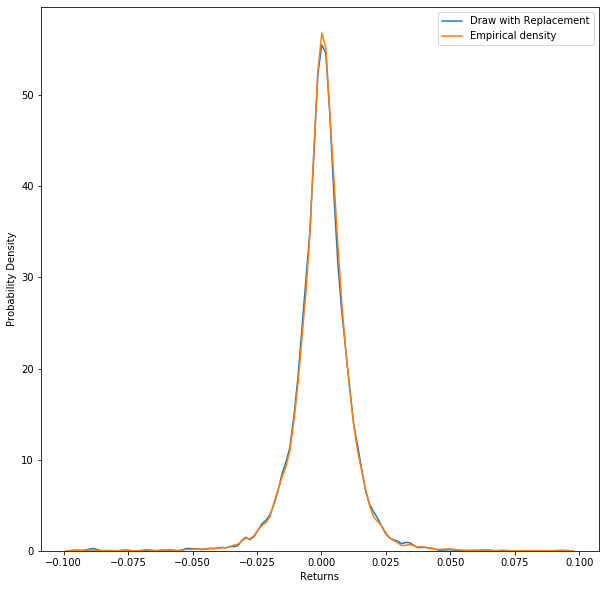

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#sns.kdeplot(data=garch['Price'].pct_change(),clip=(-0.1, 0.1),Label='GJR-GARCH(1,1)')
#sns.kdeplot(data=spx.iloc[-10437:, -2].pct_change(),clip=(-0.1, 0.1),Label='Empirical density')

#sns.kdeplot(data=tdist['Price'].pct_change(),clip=(-0.1, 0.1),Label='Skewed Students t-distribution')
#sns.kdeplot(data=spx.iloc[-10437:, -2].pct_change(),clip=(-0.1, 0.1),Label='Empirical density')

#sns.kdeplot(data=norm['Price'].pct_change(),clip=(-0.1, 0.1),Label='Normal distribution')
#sns.kdeplot(data=spx.iloc[-10437:, -2].pct_change(),clip=(-0.1, 0.1),Label='Empirical density')

sns.kdeplot(data=draw['Price'].pct_change(),clip=(-0.1, 0.1),Label='Draw with Replacement')
sns.kdeplot(data=spx.iloc[-10437:, -2].pct_change(),clip=(-0.1, 0.1),Label='Empirical density')

plt.xlabel('Returns') 
plt.ylabel('Probability Density') 


D:\Programmer\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Programmer\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Programmer\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Programmer\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0, 0.5, 'Probability Density')

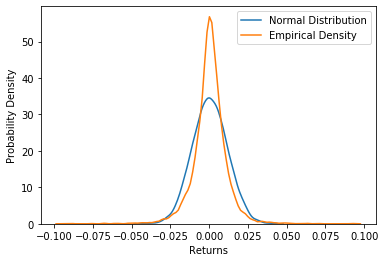

D:\Programmer\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Volatility')

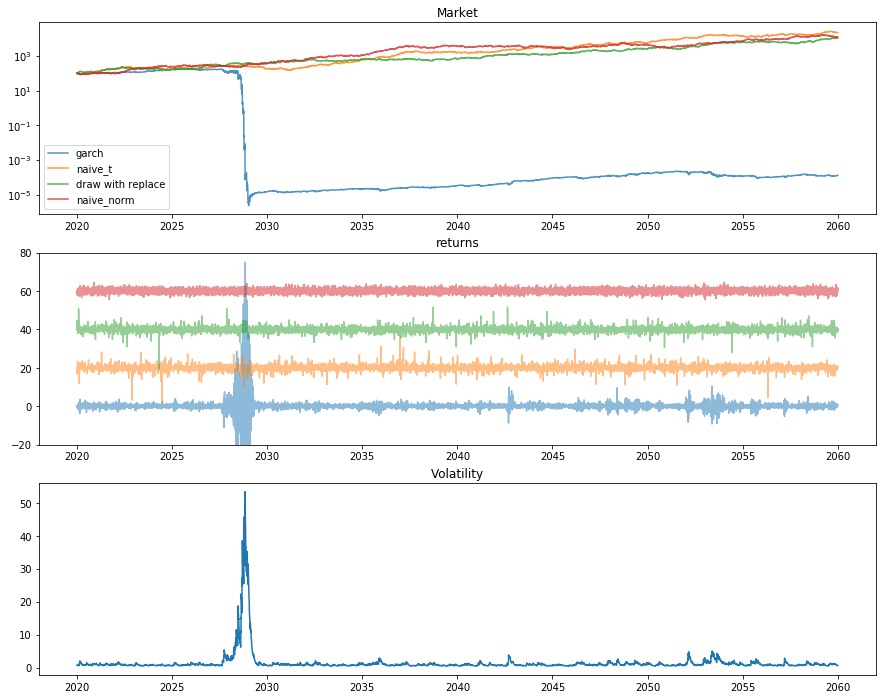

In [37]:
garch = Market.garch(log=False)
naive = Market.t_innovations(log=False)
draw = Market.draw(log = False, with_replacement = True, freq = 'D')
norm = Market.norm_innovations(log=False)

f, (ax1, ax2 , ax3) = plt.subplots(3, 1, figsize=(15,12))
ax1.plot(garch["Price"], alpha=.8)
ax1.plot(naive['Price'], alpha=.8)
ax1.plot(draw['Price'], alpha=.8)
ax1.plot(norm['Price'], alpha=.8)
ax1.set_title('Market')
ax1.legend(['garch', 'naive_t', 'draw with replace', 'naive_norm'])
ax1.set_yscale('log')

ax2.plot(garch["data"], alpha=.5)
ax2.plot(naive['Price'].pct_change()*100+20, alpha=.5)
ax2.plot(draw['Price'].pct_change()*100+40, alpha=.5)
ax2.plot(norm['Price'].pct_change()*100+60, alpha=.5)
ax2.set_ylim(-20, 80)
ax2.set_title('returns')
#ax2.set_yscale('LOG')

ax3.plot(garch["volatility"])
ax3.set_title('Volatility')
#ax3.set_yscale('LOG')

Simulating many markets

In [ ]:
def many_market(market, num_simulations):
    '''
    this simulated nobs markets with a horizon of years years

    return a dataframe with nobs columns and years*252 rows 
    '''
    data = pd.DataFrame()
    
    for i in range(num_simulations):
        data["Price_" + str(i)] = market.garch(log = True)['Price']
    return data

Descriptive statistic of simulations

In [ ]:
Market = simulate.Market(spx.iloc[-7500:, -2], start, end)
final_returns=many_market(Market, 1000).iloc[-1, :]

In [ ]:
plt.hist(final_returns, bins = 100, histtype='step', range=[-10000, 200000])
plt.show()

Prospect theory utility function

In [ ]:
def prospect_ut(price_before,price_after,alpha=0.88, beta=0.88, lambdas=2.25):
    '''
    in prospect theory, investors evaluate losses and gains differently. Assumes two different
    domains. Loss domain, where investment with negative returns are evaluted and gain domain for investment with positive return

    price_before:      the price in the begining of the evaluation period
    price_after:       the price in the end of the evulation period
    alpha:             risk aversion in gains
    beta:              risk seekingness in losses
    lambdas:           psycological harm of loss relativ to gains.

    example of price: price before: price of portfolio at 1st of january and price_after the price at 31st of janunary
    
    returns: utility u
    '''
    #absolute change
    x=price_after-price_before
    if x>=0: #if non negative absolute return
        u=x**alpha
    elif x<0:    #if negative absolute return
        u=-lambdas*(-x)**beta
    return u
    

In [ ]:
print(prospect_ut(100,250))

Constant relative risk aversion (CRRA) utility function


In [ ]:
def CRRA_ut():
    return